# Segment_and_Cluster_Neighborhoods_in_Toronto.ipynb

This JupyterLab notebook is used for the capstone project of the course
[IBM Applied Data Science Capstone](https://www.coursera.org/learn/applied-data-science-capstone)
which is part of the overall course 
[IBM Data Science Professional Certificate](https://www.coursera.org/professional-certificates/ibm-data-science).  

## Objective of this assignment
In this assignment, it is required to explore, segment, and cluster the neighborhoods in the city of Toronto.  
For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto.
It is required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format.  
Once the data is in a structured format, we can explore and cluster the neighborhoods in the city of Toronto.

## Initial step
The programming language used is **Python** of the following version

In [1]:
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [2]:
#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge geocoder --yes

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests
import io

import folium

import geocoder

from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

## Question 1
Obtain a DataFrame of PostalCode, Borough, and Neighborhood from [Wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

### Instructions (copied from assignment)
- The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
- Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
- More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
- If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
- Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
- In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

with requests.get(url, timeout=5) as response:
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find("table", class_="wikitable sortable")
    
    # extract header:
    header = table.tbody.find_all("tr")[0]
    heading = []
    for th in header.find_all("th"):
        # remove any newlines and strip
        heading.append(th.text.strip())
    
    # extract rows:
    rows = []
    table_rows = table.find_all('tr')
    for tr in table_rows:
        td = tr.find_all('td')
        rows.append([i.text.strip() for i in td])
    rows = rows[1:]
    
    # create DataFrame:
    dfQ1 = pd.DataFrame(rows, columns=heading)  
    
    # INSTRUCTION: The dataframe will consist of three columns: 
    #              PostalCode, Borough, and Neighborhood
    dfQ1.rename(columns={'Postcode': 'PostalCode',
                       'District': 'Borough', 
                       'Neighbourhood':'Neighborhood'}, inplace=True)
    
    # INSTRUCTION: Only process the cells that have an assigned borough.
    #              Ignore cells with a borough that is Not assigned:
    dfQ1.drop(dfQ1[dfQ1['Borough']=='Not assigned'].index, inplace=True)

    # INSTRUCTION: More than one neighborhood can exist in one postal code area.
    #              Combine neighborhoods of the same borough into one row with
    #              the neighborhoods separated with a comma:
    dfQ1 = dfQ1.groupby(['PostalCode','Borough'], sort=False).agg(', '.join).reset_index()
    
    # INSTRUCTION: If a cell has a borough but a Not assigned neighborhood,
    #              then the neighborhood will be the same as the borough:
    dfQ1.loc[dfQ1['Neighborhood'] =='Not assigned' , 'Neighborhood'] = dfQ1['Borough']
    
dfQ1.head(12)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park
5,M9A,Queen's Park,Queen's Park
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [4]:
dfQ1.shape

(103, 3)

## Question 2
Instructions: _We need to get the latitude and the longitude coordinates of each neighborhood._  
A csv file is used that has the geographical coordinates of each postal code: [http://cocl.us/Geospatial_data](http://cocl.us/Geospatial_data)


In [5]:
url = "http://cocl.us/Geospatial_data"
with requests.get(url, timeout=15) as response:
    if ("503" in response.text and "Service Unavailable" in response.text):
        nll = pd.read_csv("Geospatial_Coordinates.csv")
        print("Local file used.")
    else:
        rc  = response.content
        nll = pd.read_csv(io.StringIO(rc.decode('utf-8')))
        print("File loaded from internet")
    nll.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
    dfQ2 = dfQ1.join(nll.set_index('PostalCode'), on='PostalCode')
print(dfQ2.shape)    
dfQ2.head(12)   

Local file used.
(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,M9A,Queen's Park,Queen's Park,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


It is also possible to retrieve the coordinates using the `geocoder` python package.  
Here the [ArcGIS](https://geocoder.readthedocs.io/providers/ArcGIS.html) service is used:

In [6]:
if (False):  # True=fetch it from internet  ---  False=read local file
    pcLatLng= pd.DataFrame(columns = ['PostalCode', 'Latitude', 'Longitude'])
    for postal_code in dfQ1['PostalCode']:
        gc = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        row = {'PostalCode':postal_code, 'Latitude':gc.json['lat'], 'Longitude':gc.json['lng']}
        pcLatLng = pcLatLng.append(row, ignore_index=True)
    pcLatLng.to_csv("Geospatial_Coordinates_ArcGIS.csv", index =False)
    print("Data fetched from internet.")
else:
    pcLatLng = pd.read_csv("Geospatial_Coordinates_ArcGIS.csv")
    print("Local file used.")
dfQ2b = dfQ1.join(pcLatLng.set_index('PostalCode'), on='PostalCode')
print(dfQ2b.shape)    
dfQ2b.head(12)   

Local file used.
(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752420,-79.329242
1,M4A,North York,Victoria Village,43.730600,-79.313265
2,M5A,Downtown Toronto,Harbourfront,43.650295,-79.359166
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.723270,-79.451286
4,M7A,Downtown Toronto,Queen's Park,43.661150,-79.391715
5,M9A,Queen's Park,Queen's Park,43.662299,-79.528195
6,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517
7,M3B,North York,Don Mills North,43.749055,-79.362227
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.707535,-79.311773
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657363,-79.378180


There are small differences between the coordinates that come from these two different sources.  
Let's visualize them in the next chapter.

## Question 3
Instructions: _Explore and cluster the neighborhoods in Toronto.  
You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data._

### Q3.1 Visualize coordinates of neighborhoods
For the first investigations the data was reduced to boroughs which contain the word _Toronto_.  
After all the following steps on the reduced data were successfully performed, all the steps were executed again using the whole data... 

In [7]:
dfQ3  = dfQ2[ dfQ2[ "Borough"].str.contains("Toronto")].reset_index(drop=True)
dfQ3b = dfQ2b[dfQ2b["Borough"].str.contains("Toronto")].reset_index(drop=True)
dfQ3  = dfQ2    # comment out for reduced data set
dfQ3b = dfQ2b   # comment out for reduced data set
print(dfQ3.shape)
dfQ3.head(12)

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,M9A,Queen's Park,Queen's Park,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


In [8]:
print('There are {} unique Neighborhoods.'.format(len(dfQ3['Neighborhood'].unique())))

There are 102 unique Neighborhoods.


In [9]:
# check dfQ3 for NaN / empty cells
print(dfQ3.isna().sum())

PostalCode      0
Borough         0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64


Get the geographical coordinates of Toronto to center the map. The `mean()` over all the interesting coordinates will do the job:

In [10]:
# get the geographical coordinates of Toronto
latitude  = dfQ3["Latitude"].mean()
longitude = dfQ3["Longitude"].mean()
print('The geograpical coordinate of Toronto  {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto  43.70460773398059, -79.39715291165048.


In [11]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(dfQ3['Latitude'], dfQ3['Longitude'], dfQ3['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

# add markers to map
for lat, lng, label in zip(dfQ3b['Latitude'], dfQ3b['Longitude'], dfQ3b['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#86cc31',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Both data sets (blue + green) show mostly similar geographic coordinates of the neighborhoods.  
The blue record that comes from the file [http://cocl.us/Geospatial_data](http://cocl.us/Geospatial_data) seems to have more meaningful points.  
In the following we will use this blue data set.

### Q3.2 Retrieve venue data of neighborhoods using https://foursquare.com

In [12]:
import MyCredentials  # MyCredentials.py stores the info to keep my credentials hidden
FOURSQUARE_CLIENT_ID = MyCredentials.FOURSQUARE_CLIENT_ID # your Foursquare ID
FOURSQUARE_CLIENT_SECRET = MyCredentials.FOURSQUARE_CLIENT_SECRET # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 150 # define radius

#print('Your credentails:')
#print('CLIENT_ID: ' + FOURSQUARE_CLIENT_ID)
#print('CLIENT_SECRET:' + FOURSQUARE_CLIENT_SECRET)

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
toronto_venues = getNearbyVenues(names=dfQ3['Neighborhood'],
                                 latitudes=dfQ3['Latitude'],
                                 longitudes=dfQ3['Longitude']
                                )

Parkwoods
Victoria Village
Harbourfront
Lawrence Heights, Lawrence Manor
Queen's Park
Queen's Park
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The Danforth West, Riv

### Q3.3 Check retrieved data and clean it

In [15]:
# size of the dataframe and a first glimpse:
print(toronto_venues.shape)
toronto_venues.head(12)

(2222, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
5,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
6,Harbourfront,43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
7,Harbourfront,43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
8,Harbourfront,43.654260,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
9,Harbourfront,43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


Check how many venues were returned for each neighborhood

In [16]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",8,8,8,8,8,8
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Downsview North, Wilson Heights",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Berczy Park,57,57,57,57,57,57


Let's find out how many unique categories can be curated from all the returned venues

In [17]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))
# toronto_venues['Venue Category'].unique()

There are 273 unique categories.


In [18]:
print('There are {} unique Neighborhoods.'.format(len(toronto_venues['Neighborhood'].unique())))

There are 100 unique Neighborhoods.


There are 4 entries with "Venue Category" = "Neighborhood".

In [19]:
toronto_venues[toronto_venues['Venue Category'].str.contains("Neighborhood") == True]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
384,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
646,"Adelaide, King, Richmond",43.650571,-79.384568,Downtown Toronto,43.653232,-79.385296,Neighborhood
818,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,Harbourfront,43.639526,-79.380688,Neighborhood
1303,Studio District,43.659526,-79.340923,Leslieville,43.662070,-79.337856,Neighborhood


Let's remove these entries ("Venue Category" = "Neighborhood"), otherwise these entries will lead to problems later on...

In [20]:
print(toronto_venues.shape)
toronto_venues_clean = toronto_venues[toronto_venues['Venue Category'].str.contains("Neighborhood") == False]
print(toronto_venues_clean.shape)

(2222, 7)
(2218, 7)


### Q3.4 Analyse data

Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [21]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_clean[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column as first column
toronto_onehot.insert(0,'Neighborhood', toronto_venues_clean['Neighborhood'])
print(toronto_onehot.shape)

(2218, 273)


In [22]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020202,...,0.020202,0.00,0.000000,0.000000,0.000000,0.010101,0.000000,0.000000,0.010101,0.000000
1,Agincourt,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Alderwood, Long Branch",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Bathurst Manor, Downsview North, Wilson Heights",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Bayview Village,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Bedford Park, Lawrence Manor East",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.017544,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Birch Cliff, Cliffside West",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
toronto_grouped.shape

(100, 273)

 Print the top 5 most common venues for each neighborhood 

In [24]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.08
1             Café  0.05
2       Steakhouse  0.04
3              Bar  0.04
4  Thai Restaurant  0.03


----Agincourt----
                       venue  freq
0                     Lounge  0.25
1             Breakfast Spot  0.25
2  Latin American Restaurant  0.25
3             Clothing Store  0.25
4          Accessories Store  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                 venue  freq
0           Playground  0.33
1                 Park  0.33
2          Coffee Shop  0.33
3        Metro Station  0.00
4  Monument / Landmark  0.00


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0         Grocery Store  0.25
1              Pharmacy  0.12
2           Pizza Place  0.12
3  Fast Food Restaurant  0.12
4            Beer Store  0.12


----Alderwood, Long Branch----
            v

Display the top 10 venues for each neighborhood.

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(12)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Burger Joint,Sushi Restaurant,Restaurant,Asian Restaurant,Thai Restaurant,Gym
1,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Clothing Store,Farmers Market,Fast Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Discount Store
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Coffee Shop,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Pharmacy,Sandwich Place,Pizza Place,Airport Service,Festival,Farmers Market
4,"Alderwood, Long Branch",Pizza Place,Pharmacy,Skating Rink,Dance Studio,Coffee Shop,Pub,Sandwich Place,Gym,Airport Terminal,Festival
5,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Pet Store,Frozen Yogurt Shop,Bridal Shop,Shopping Mall,Fast Food Restaurant,Sandwich Place,Diner,Restaurant,Supermarket
6,Bayview Village,Japanese Restaurant,Chinese Restaurant,Bank,Café,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Discount Store
7,"Bedford Park, Lawrence Manor East",Coffee Shop,Pizza Place,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Fast Food Restaurant,Café,Liquor Store,Pub,Butcher
8,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Seafood Restaurant,Beer Bar,Cheese Shop,Farmers Market,Bakery,Café,Breakfast Spot
9,"Birch Cliff, Cliffside West",College Stadium,Skating Rink,General Entertainment,Café,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Event Space,Eastern European Restaurant,Dim Sum Restaurant


### Q3.5 Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [26]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 3, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2], dtype=int32)

It looks like the labels are very unevenly distributed. Use a histogram to visualize it.

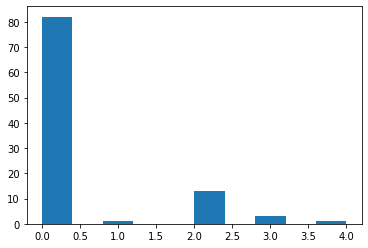

In [27]:
plt.hist(kmeans.labels_)
plt.show()

It turns out that the neighborhoods do not cluster into a _nice_ distribution.  
Next step: Join the original data (i.e. _PostalCode_, _Borough_, _Neighborhood_, _Latitude_, _Longitude_) with the anlysis of the _Most Common Venues_.
Also add the _Cluster Labels_ accordingly.

In [28]:
# add clustering labels
if not 'Cluster Labels' in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = dfQ3

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='inner')

#toronto_merged
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Food & Drink Shop,Park,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Hockey Arena,French Restaurant,Portuguese Restaurant,Coffee Shop,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Pub,Mexican Restaurant,Restaurant,Café,Breakfast Spot,Brewery,French Restaurant
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,0,Clothing Store,Accessories Store,Coffee Shop,Shoe Store,Miscellaneous Shop,Fraternity House,Carpet Store,Furniture / Home Store,Boutique,Gift Shop
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,0,Coffee Shop,Gym,Park,Yoga Studio,Hobby Shop,Diner,Beer Bar,Bar,Chinese Restaurant,Sushi Restaurant


Visualize the clusters:

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Q3.6 Examin clusters

Let's take a look on the clustered neighborhoods...

#### Cluster 1

In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0,Hockey Arena,French Restaurant,Portuguese Restaurant,Coffee Shop,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,Downtown Toronto,0,Coffee Shop,Bakery,Park,Pub,Mexican Restaurant,Restaurant,Café,Breakfast Spot,Brewery,French Restaurant
3,North York,0,Clothing Store,Accessories Store,Coffee Shop,Shoe Store,Miscellaneous Shop,Fraternity House,Carpet Store,Furniture / Home Store,Boutique,Gift Shop
4,Downtown Toronto,0,Coffee Shop,Gym,Park,Yoga Studio,Hobby Shop,Diner,Beer Bar,Bar,Chinese Restaurant,Sushi Restaurant
5,Queen's Park,0,Coffee Shop,Gym,Park,Yoga Studio,Hobby Shop,Diner,Beer Bar,Bar,Chinese Restaurant,Sushi Restaurant
6,Scarborough,0,Fast Food Restaurant,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
7,North York,0,Café,Japanese Restaurant,Gym / Fitness Center,Caribbean Restaurant,Baseball Field,Basketball Court,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
8,East York,0,Fast Food Restaurant,Pizza Place,Pharmacy,Athletics & Sports,Gastropub,Intersection,Pet Store,Bank,Gym / Fitness Center,American Restaurant
9,Downtown Toronto,0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Lingerie Store,Fast Food Restaurant,Tea Room,Bookstore,Diner
10,North York,0,Japanese Restaurant,Bakery,Italian Restaurant,Pub,Yoga Studio,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant


#### Cluster 2

In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,North York,1,Cafeteria,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Comfort Food Restaurant


#### Cluster 3

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,2,Food & Drink Shop,Park,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
21,York,2,Park,Women's Store,Market,Fast Food Restaurant,Construction & Landscaping,Convenience Store,Farmers Market,Falafel Restaurant,Event Space,Concert Hall
35,East York,2,Park,Convenience Store,Coffee Shop,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
40,North York,2,Airport,Park,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
61,Central Toronto,2,Park,Bus Line,Swim School,Yoga Studio,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
64,York,2,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
66,North York,2,Park,Convenience Store,Bank,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
68,Central Toronto,2,Trail,Park,Jewelry Store,Sushi Restaurant,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
77,Etobicoke,2,Pizza Place,Park,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
83,Central Toronto,2,Summer Camp,Playground,Park,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant


#### Cluster 4

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,North York,3,Food Truck,Baseball Field,Yoga Studio,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Discount Store
57,North York,3,Baseball Field,Furniture / Home Store,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
101,Etobicoke,3,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field


#### Cluster 5

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Scarborough,4,Playground,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Colombian Restaurant


### Summary
There are only three clusters containing several entries which can be described as follows:
* Coffee Shop / Cafe / Restaurants
* Park / Trail / Dog Run / Playground
* Baseball Field

The other "clusters" are sparsely populated.